In [1]:
import pandas as pd
import gymnasium as gym
import numpy as np

from dist_plot import plot_q_values_map
from dist_q import EpsilonGreedy
from dist_run import Params, run_env_quantile, postprocess

In [2]:
params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=(4, 12),
    seed=123,
    is_slippery=True,
    n_runs=20,
    action_size=None,
    state_size=None,
    n_quantiles=51,
)

rng = np.random.default_rng(params.seed)

In [3]:
res_all = pd.DataFrame()
st_all = pd.DataFrame()

env = gym.make(
    "CliffWalking-v1",
    is_slippery=params.is_slippery,
    shape=params.map_size,
    render_mode="rgb_array",
)
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
env.action_space.seed(params.seed)

explorer = EpsilonGreedy(params.epsilon, rng)
rewards, steps, episodes, qtables, all_states, all_actions = run_env_quantile(env, explorer, params)

# Save the results in dataframes
res, st = postprocess(episodes, params, rewards, steps)
res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

env.close()

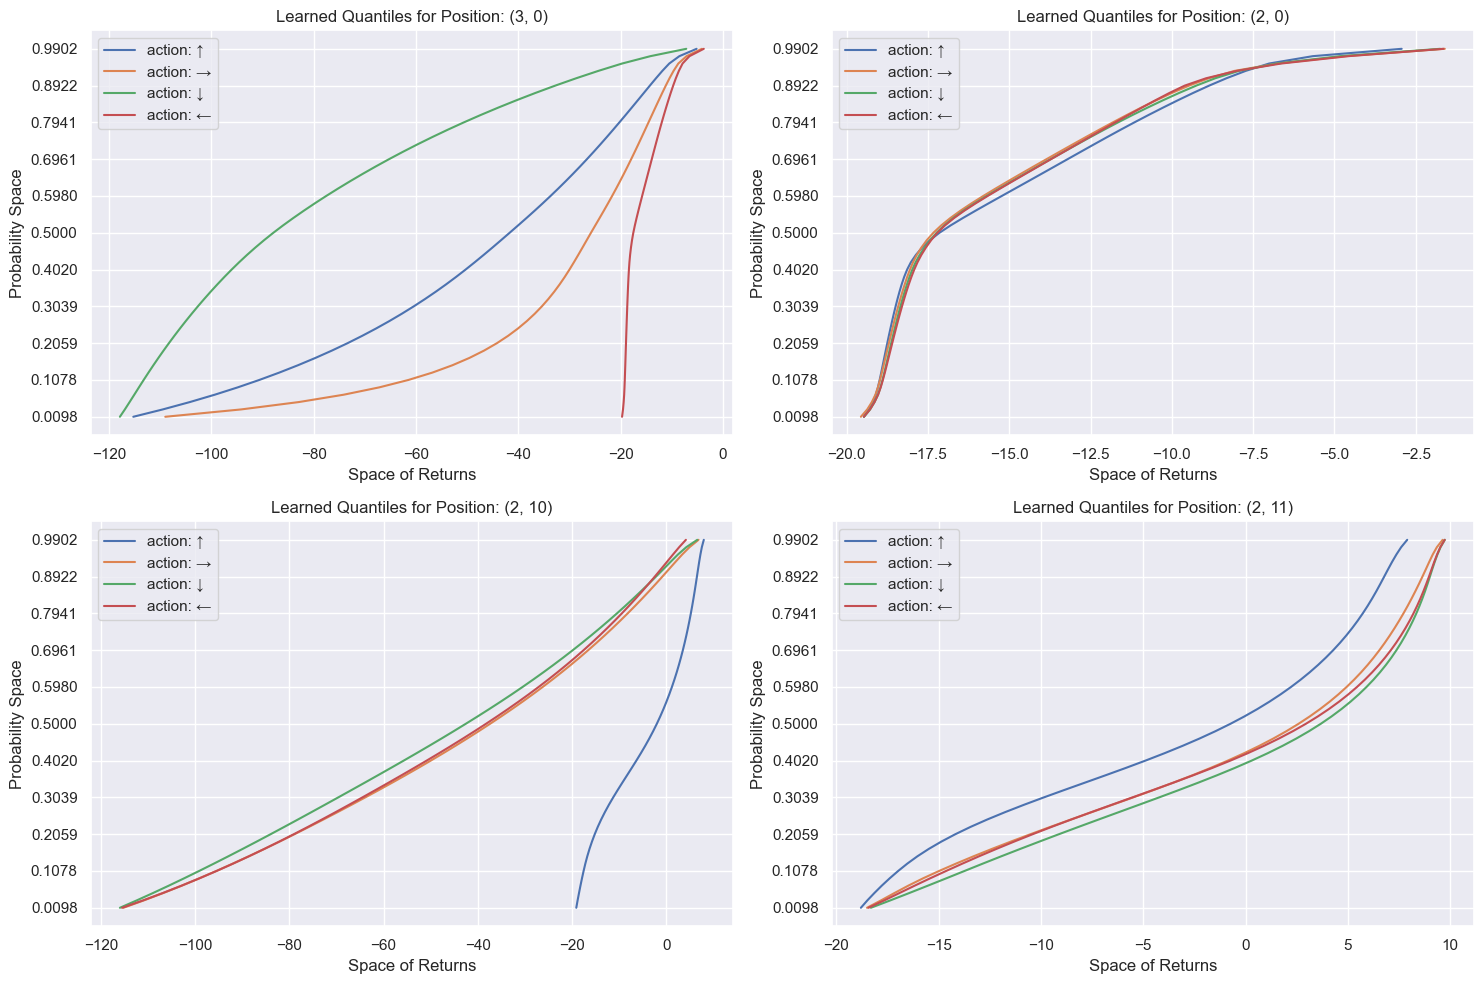

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
tau = ((2 * np.arange(params.n_quantiles) + 1) / (2.0 * params.n_quantiles))
arrow_directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, pos in enumerate([(3, 0), (2, 0), (2, 10), (2, 11)]):
    ax = axes[i]
    state = np.ravel_multi_index(pos, params.map_size)

    for j, quantiles in enumerate(qtable[state]):
        ax.plot(quantiles, tau, label=f"action: {arrow_directions[j]}")

    ax.set_title(f"Learned Quantiles for Position: {pos}")
    ax.set_xlabel("Space of Returns")
    ax.set_ylabel("Probability Space")
    ax.set_yticks(tau[::5])
    ax.legend()

plt.tight_layout()
plt.show()

In [7]:
for i, pos in enumerate([(3, 0), (2, 0), (2, 10), (2, 11)]):
    state = np.ravel_multi_index(pos, params.map_size)
    print(f"position: {i} | q_value : {qtable.mean(2)[state]}")

position: 0 | q_value : [-47.31481335 -31.8535346  -79.59810001 -15.63245419]
position: 1 | q_value : [-15.15406494 -15.34359933 -15.24815313 -15.25137222]
position: 2 | q_value : [ -4.19043255 -43.29088448 -46.98397113 -44.13987436]
position: 3 | q_value : [-3.35203245 -0.64566268  0.26389967 -0.35698404]


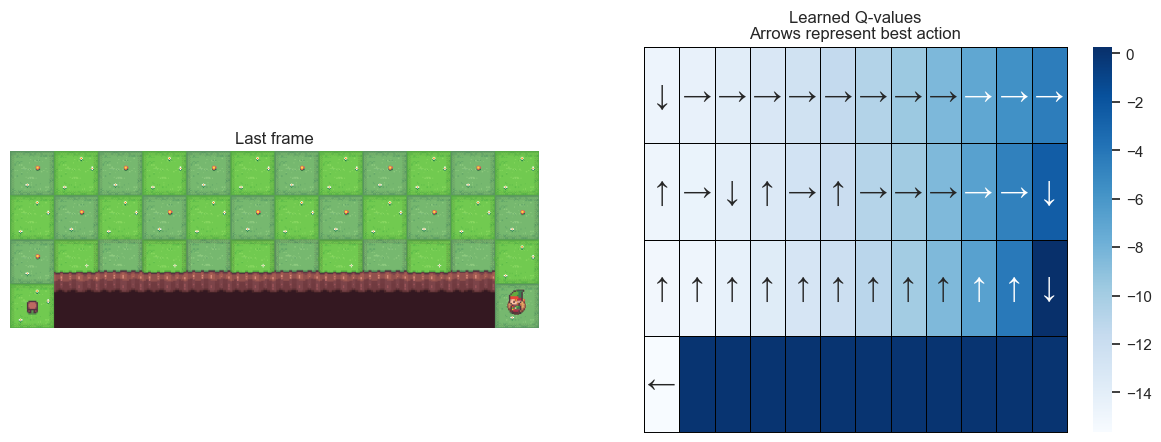

In [6]:
plot_q_values_map(qtable.mean(2), env, params.map_size)